# Libraries and functions initialization

In [4]:
library(repr)
options(repr.plot.width=11, repr.plot.height=7, repr.plot.res = 80, repr.plot.quality = 40)
options(jupyter.plot_mimetypes = 'image/png')

setwd("~/yandexDisk/DIPLOMA/CODE/src")
source("simulations.functions.R", echo=FALSE)
source("../../OWL/O_learning_functions.r", echo=FALSE)
debug.file <- ".various.Rdata/Iter.info"
set.seed(0)

Loading SVMW


In [5]:
# Defining control execution constants 
train.data.sample.sizes <- c(50, 100, 200, 400, 800)
test.data.sample.size <- 10000
sample.size <- 200
offsets = seq(0.2, 1, length = 10)
control.offset = min(offsets) / 2
lambdas = seq(0,  10,  length=12)
scenario = "chen.2"

registerDoParallel(cores = 4)
number.of.iters <- 20

offset = 0.1
lambda = 1

In [6]:
test <- GetSimulationData(test.data.sample.size, scenario = scenario)
train <- GetSimulationData(sample.size, scenario = scenario)

# Simulation specific functions

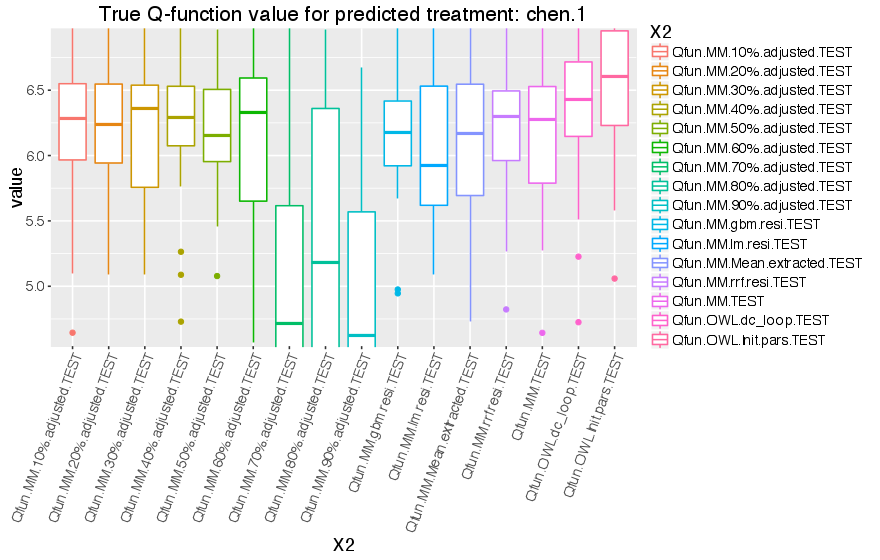

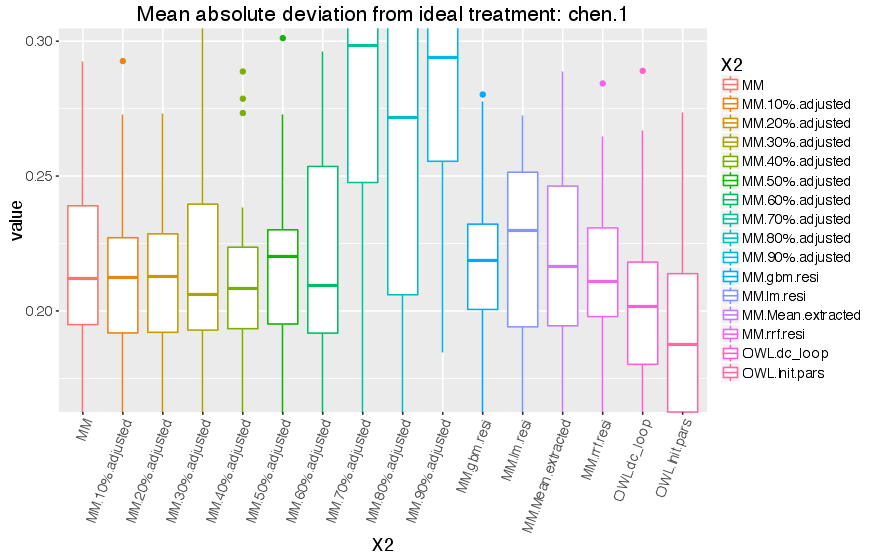

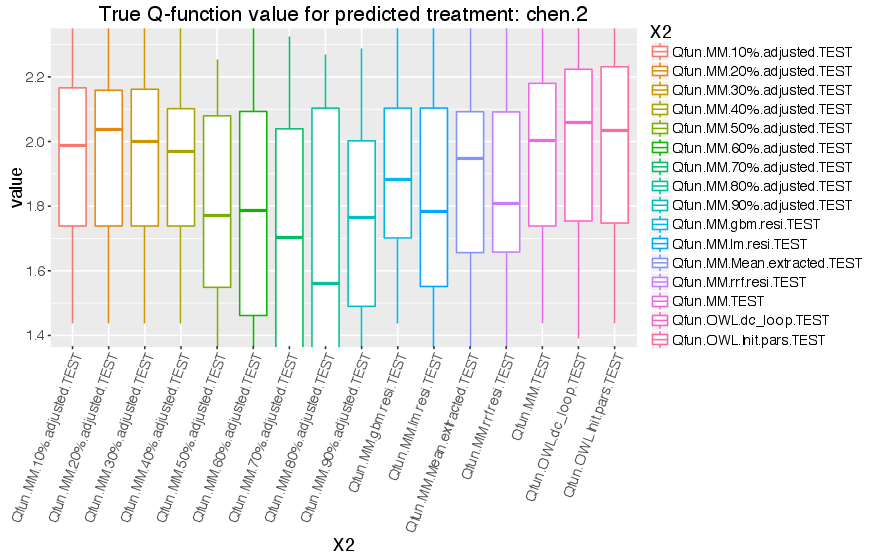

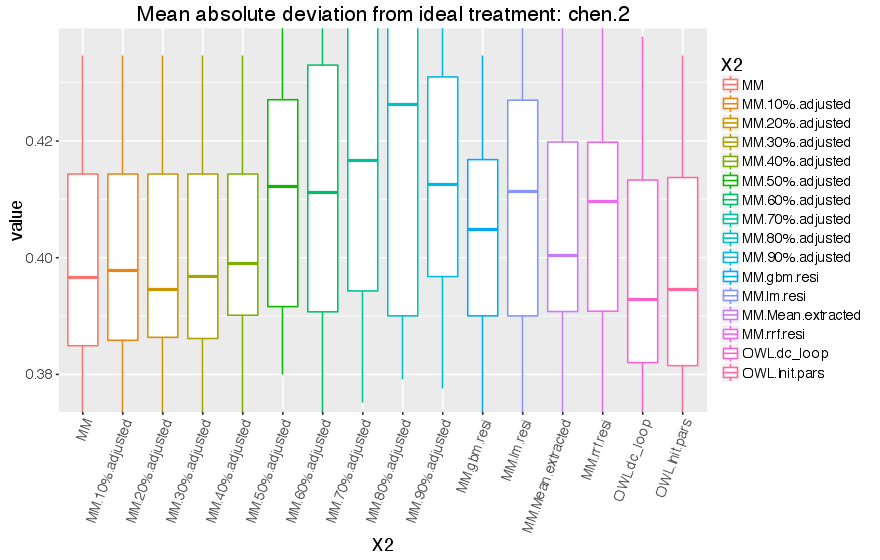

In [356]:
quants <- seq(10, 90, 10) / 100

for (scenario in c("chen.1", "chen.2")) {
    global.stat <- numeric()
    global.abs.dev <- numeric()
    test <- GetSimulationData(test.data.sample.size, scenario = scenario) 
    for (i in seq(1,number.of.iters)) { 
        train <- GetSimulationData(sample.size, scenario = scenario)
        ## Without correction
        init.pars = GetOwlParams(train, lambda, weights = F)
        opt.params <- list("opt.func"=DCOptimizeWithMML2PenalizedProperIters, "tolerance"=1e-7, "init.pars"=init.pars, "approximation.eps"=1e-7)
        pars.dca.MM <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt=opt.params)
        pars.owl.dc_loop <- GetDCLoopPars(train, offset, lambda, init.pars)
        ## Correction
        lm_model <- with(train, lm(raw.R ~ . - 1, data=data.frame(raw.R = raw.reward, covariates)))
        train$reward <- residuals(lm_model)
        pars.dca.MM.res <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt=opt.params)
        train$reward <- with(train, raw.reward - mean(raw.reward))
        pars.dca.MM.mean.extracted <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt=opt.params)
        rewards.q.adjusted <- lapply(quantile(train$raw.reward, quants), function(q) with(train, {raw.reward - q}))
        names(rewards.q.adjusted) <- sapply(names(rewards.q.adjusted), function(n) paste("MM", n, "adjusted", sep = "."))
        pars.dca.MM.quants.extracted <- lapply(rewards.q.adjusted, function(reward.adj) {
            train$reward <- reward.adj
            OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt=opt.params)
        })
        
        # experiment with randomForest 
        rf_model <- with(train, randomForest(covariates,  raw.reward, ntree=1000, mtry=3)) 
        train$reward <- with(train, raw.reward - predict(rf_model, covariates))
        pars.dca.MM.res.rrf <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt=opt.params)
            
        # experiment with boosting
        gbm_model <- with(train, train(raw.R ~ ., data=data.frame(raw.R = raw.reward, covariates[, -1]), method="gbm", tuneLength = 7, verbose = FALSE))
        train$reward <- with(train, raw.reward - predict(gbm_model, covariates))
        pars.dca.MM.res.gbm <- OptimizeParamsOfPolicyFunction(train, offset, PolicyFunLinearKernel, lambda, opt=opt.params)
        
            
            
        data.list <- list("train"=train, "test"=test)
        params.list  <- list(
                             "OWL.Init.pars"=init.pars,
                             "MM"=pars.dca.MM, 
                             "OWL.dc_loop"=pars.owl.dc_loop, 
                             "MM.lm.resi"=pars.dca.MM.res, 
                             "MM.Mean.extracted" = pars.dca.MM.mean.extracted, 
                             "MM.rrf.resi" = pars.dca.MM.res.rrf, 
                             "MM.gbm.resi" = pars.dca.MM.res.gbm
                            ) 
        params.list <- c(params.list, pars.dca.MM.quants.extracted)
        iter.stat <- GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
        global.stat  <- rbind(global.stat, iter.stat)
        mean.abs.deviation <- sapply(params.list, 
            function(p) with(test, mean(abs(optimal.treatment - PolicyFunLinearKernel(p, covariates)))))
        global.abs.dev <- rbind(global.abs.dev, mean.abs.deviation)

    }

    rownames(global.stat) <- NULL
    q.test <- melt(global.stat[, grep("Q.*TEST", colnames(global.stat))])
    gg <- ggplot(q.test)  + 
        geom_boxplot(aes(X2, value, color=X2)) + 
        theme(axis.text.x=element_text(angle = 70, hjust=1), text = element_text(size=15)) +         
        ggtitle(paste("True Q-function value for predicted treatment:", scenario))
    gg <- gg + coord_cartesian(ylim=quantile(gg$data$value, c(0.1, 0.9))) 
    print(gg)
    rownames(global.abs.dev) <- NULL
    gg <- ggplot(melt(global.abs.dev)) + 
        geom_boxplot(aes(X2, value,  colour=X2)) + 
        theme(axis.text.x=element_text(angle = 70, hjust = 1), text = element_text(size=15)) + 
        ggtitle(paste("Mean absolute deviation from ideal treatment:", scenario))
    gg <- gg + coord_cartesian(ylim=quantile(gg$data$value, c(0.1, 0.9))) 
    print(gg)
}

# Experiments: OWL (dc_loop) versus quantile regression on best 40%

### Two scenarios from Chen2016 (chen.1 and chen.2)

In [17]:
global.stat <- numeric()
global.abs.dev <- numeric()

for (scenario in c("chen.1", "chen.2")) { 
    test <- GetSimulationData(test.data.sample.size, scenario = scenario)
    for (i in seq(1,number.of.iters)) {
        train <- GetSimulationData(sample.size, scenario = scenario)
        init.pars = GetOwlParams(train, lambda, weights = F)
        pars.owl.dc_loop <- GetDCLoopPars(train, offset, lambda, init.pars)


        data.list <- list("train"=train, "test"=test)
        params.list  <- list(
                             "OWL.Init.pars"=init.pars,
                             "OWL.dc_loop"=pars.owl.dc_loop
                            ) 
        iter.stat <- GetMetricsForParams(params.list, data.list, offset, PolicyFunLinearKernel, lambda)
        global.stat  <- rbind(global.stat, iter.stat)
        mean.abs.deviation <- sapply(params.list, 
            function(p) with(test, mean(abs(optimal.treatment - PolicyFunLinearKernel(p, covariates)))))
        global.abs.dev <- rbind(global.abs.dev, mean.abs.deviation)

    }

    rownames(global.stat) <- NULL
    q.test <- melt(global.stat[, grep("Q.*TEST", colnames(global.stat))])
    gg <- ggplot(q.test, aes(X1, value))  + geom_boxplot(aes(colour = X2)) + 
                                     theme(text = element_text(size=15)) +
                                     ggtitle(paste("True Q-function value for predicted treatment:", scenario))

                                     
    rownames(global.abs.dev) <- NULL
    gg <- ggplot(melt(global.abs.dev)) + geom_boxplot(aes(X2, value,  colour=X2)) + 
                                     theme(text = element_text(size=15)) +
                                     ggtitle(paste("Mean absolute deviation from ideal treatment:", scenario))
    
}

# 2 – Scenario from Chen2016